# Consensus Non-negative Matrix factorization (cNMF)

cNMF is an analysis pipeline for inferring gene expression programs from single-cell RNA-Seq (scRNA-Seq) data.

It takes a count matrix (N cells X G genes) as input and produces a (K x G) matrix of gene expression programs (GEPs) and a (N x K) matrix specifying the usage of each program for each cell in the data. You can read more about the method in the [github](https://github.com/dylkot/cNMF) and check out examples on dentategyrus.

In [2]:
import scanpy as sc
import omicverse as ov
ov.plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.9, Tutorials: https://omicverse.readthedocs.io/


## Loading dataset

Here, we use the dentategyrus dataset as an example for cNMF.

In [ ]:
import scvelo as scv
adata=scv.datasets.dentategyrus()

In [4]:
%%time
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata

Begin robust gene identification
After filtration, 13264/13913 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 0.8343114852905273 seconds.
End of size normalization: shiftlog and HVGs selection pearson
CPU times: user 803 ms, sys: 132 ms, total: 935 ms
Wall time: 933 ms


AnnData object with n_obs × n_vars = 2930 × 13189
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    var: 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'clusters_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

<AxesSubplot: title={'center': 'Celltypes'}, xlabel='X_umap1', ylabel='X_umap2'>

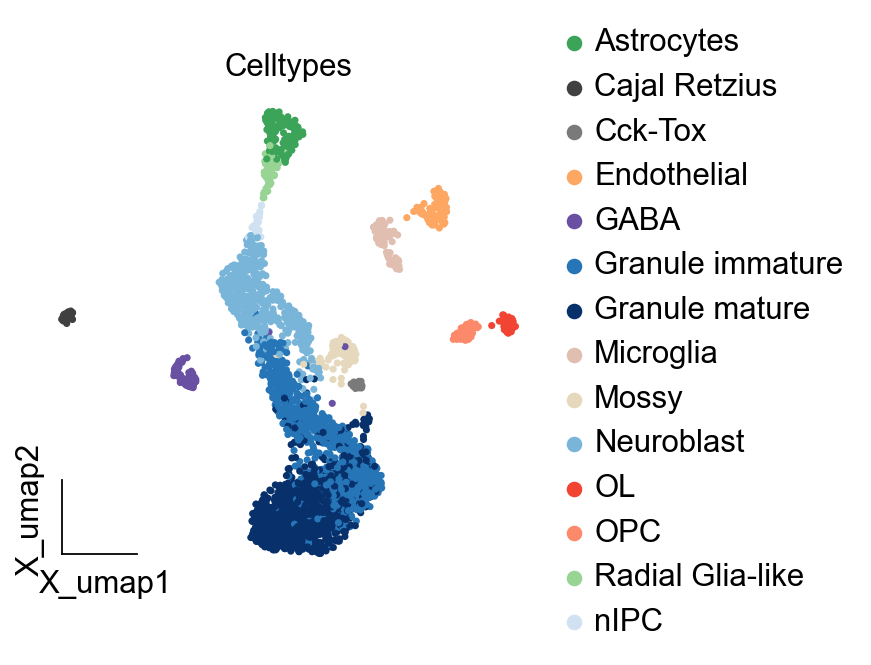

In [5]:
import matplotlib.pyplot as plt
from matplotlib import patheffects
fig, ax = plt.subplots(figsize=(4,4))
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=['clusters'],
    frameon='small',
    title="Celltypes",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    #size=10,
    ax=ax,
    #legend_loc=True, 
    add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
)

## Initialize and Training model

In [6]:
import numpy as np
## Initialize the cnmf object that will be used to run analyses
cnmf_obj = ov.single.cNMF(adata,components=np.arange(5,11), n_iter=20, seed=14, num_highvar_genes=2000,
                          output_dir='example_dg/cNMF', name='dg_cNMF')

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [7]:
## Specify that the jobs are being distributed over a single worker (total_workers=1) and then launch that worker
cnmf_obj.factorize(worker_i=0, total_workers=2)

60it [00:13,  4.34it/s]


In [8]:
cnmf_obj.combine()

Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.


## Compute the stability and error at each choice of K to see if a clear choice jumps out.

Please note that the maximum stability solution is not always the best choice depending on the application. However it is often a good starting point even if you have to investigate several choices of K

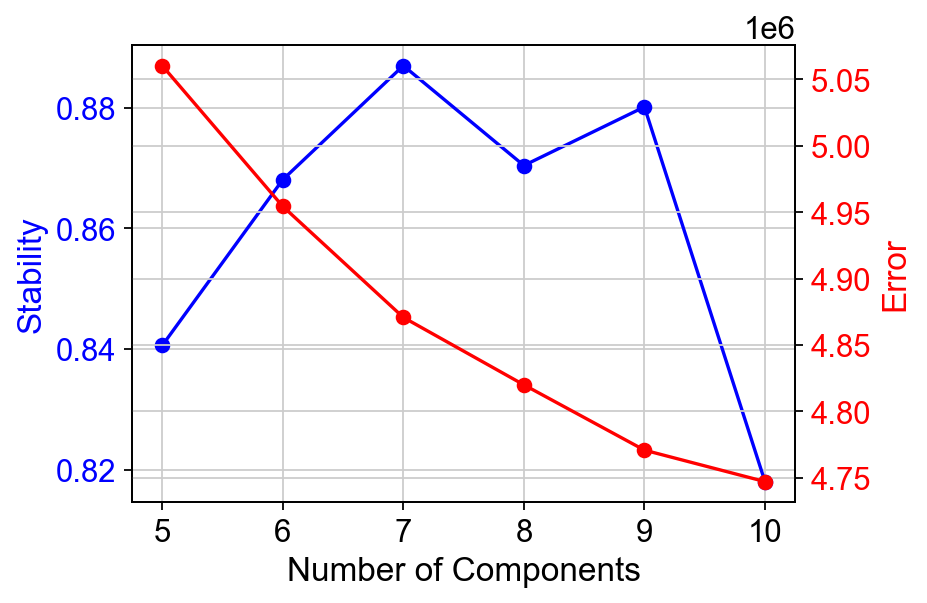

In [9]:
cnmf_obj.k_selection_plot(close_fig=False)

In this range, K=7 gave the most stable solution so we will begin by looking at that.

The next step computes the consensus solution for a given choice of K. We first run it without any outlier filtering to see what that looks like. Setting the density threshold to anything >= 2.00 (the maximum possible distance between two unit vectors) ensures that nothing will be filtered.

Then we run the consensus with a filter for outliers determined based on inspecting the histogram of distances between components and their nearest neighbors

In [10]:
selected_K = 7
density_threshold = 2.00

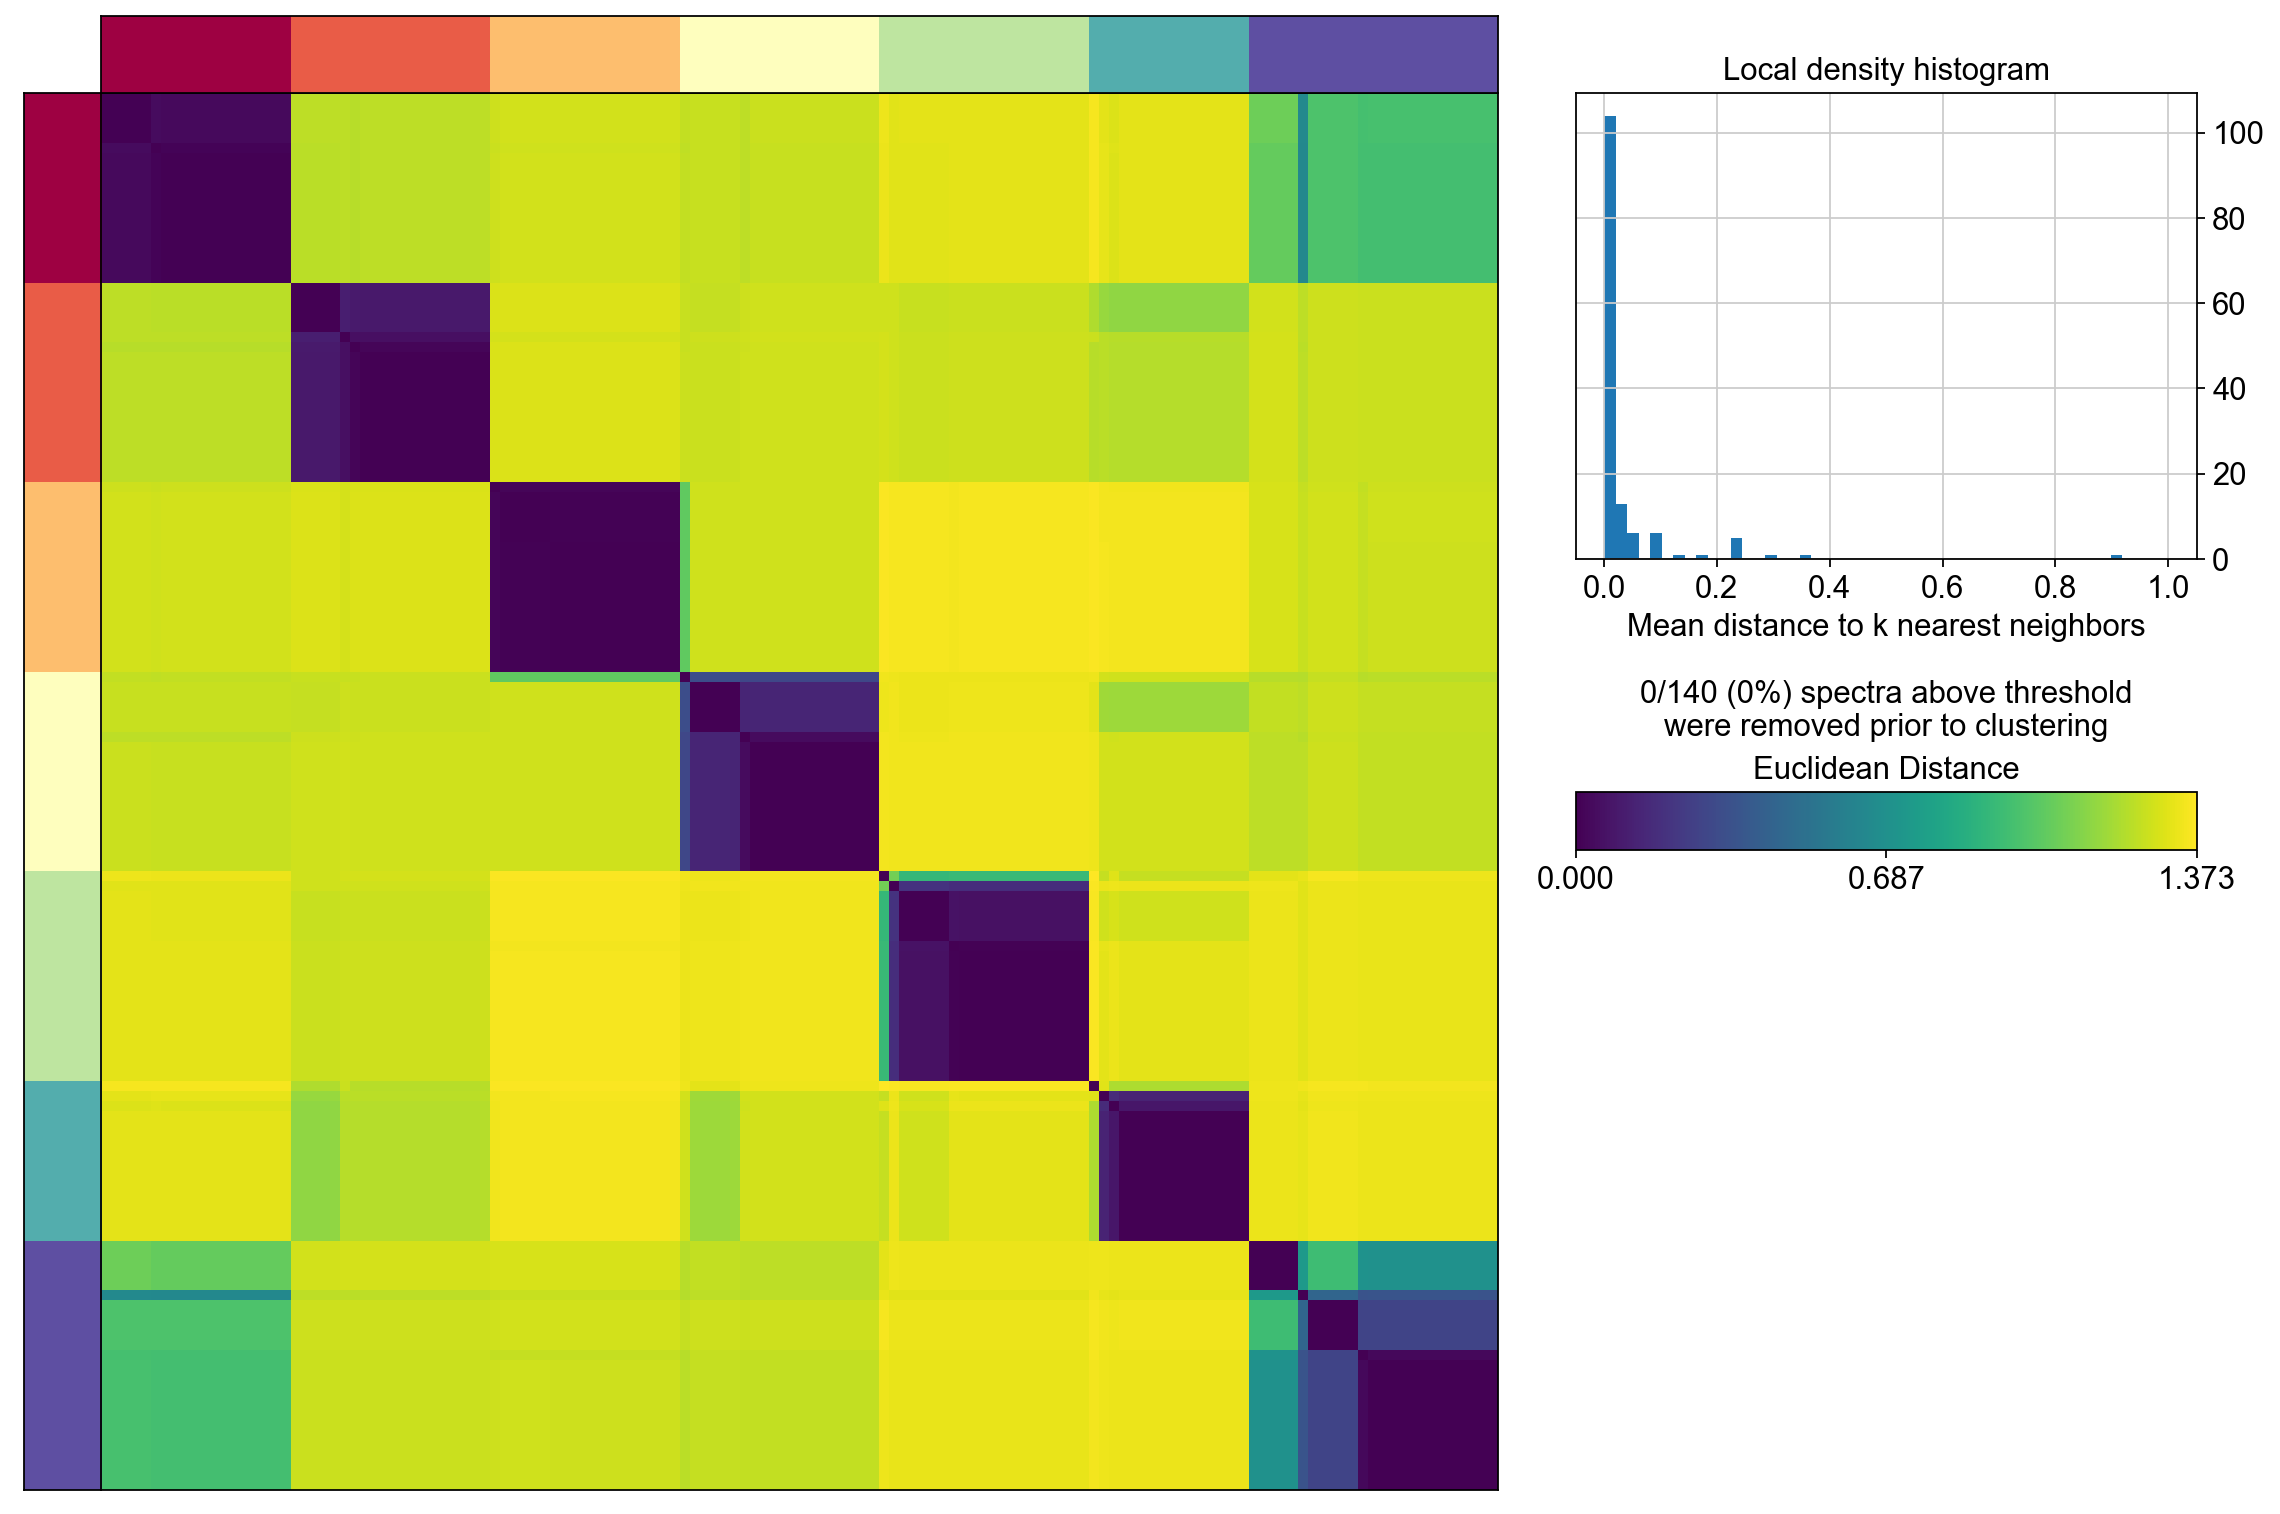

In [11]:
cnmf_obj.consensus(k=selected_K, 
                   density_threshold=density_threshold, 
                   show_clustering=True, 
                   close_clustergram_fig=False)

The above consensus plot shows that there is a substantial degree of concordance between the replicates with a few outliers. An outlier threshold of 0.1 seems appropriate

In [12]:
density_threshold = 0.10

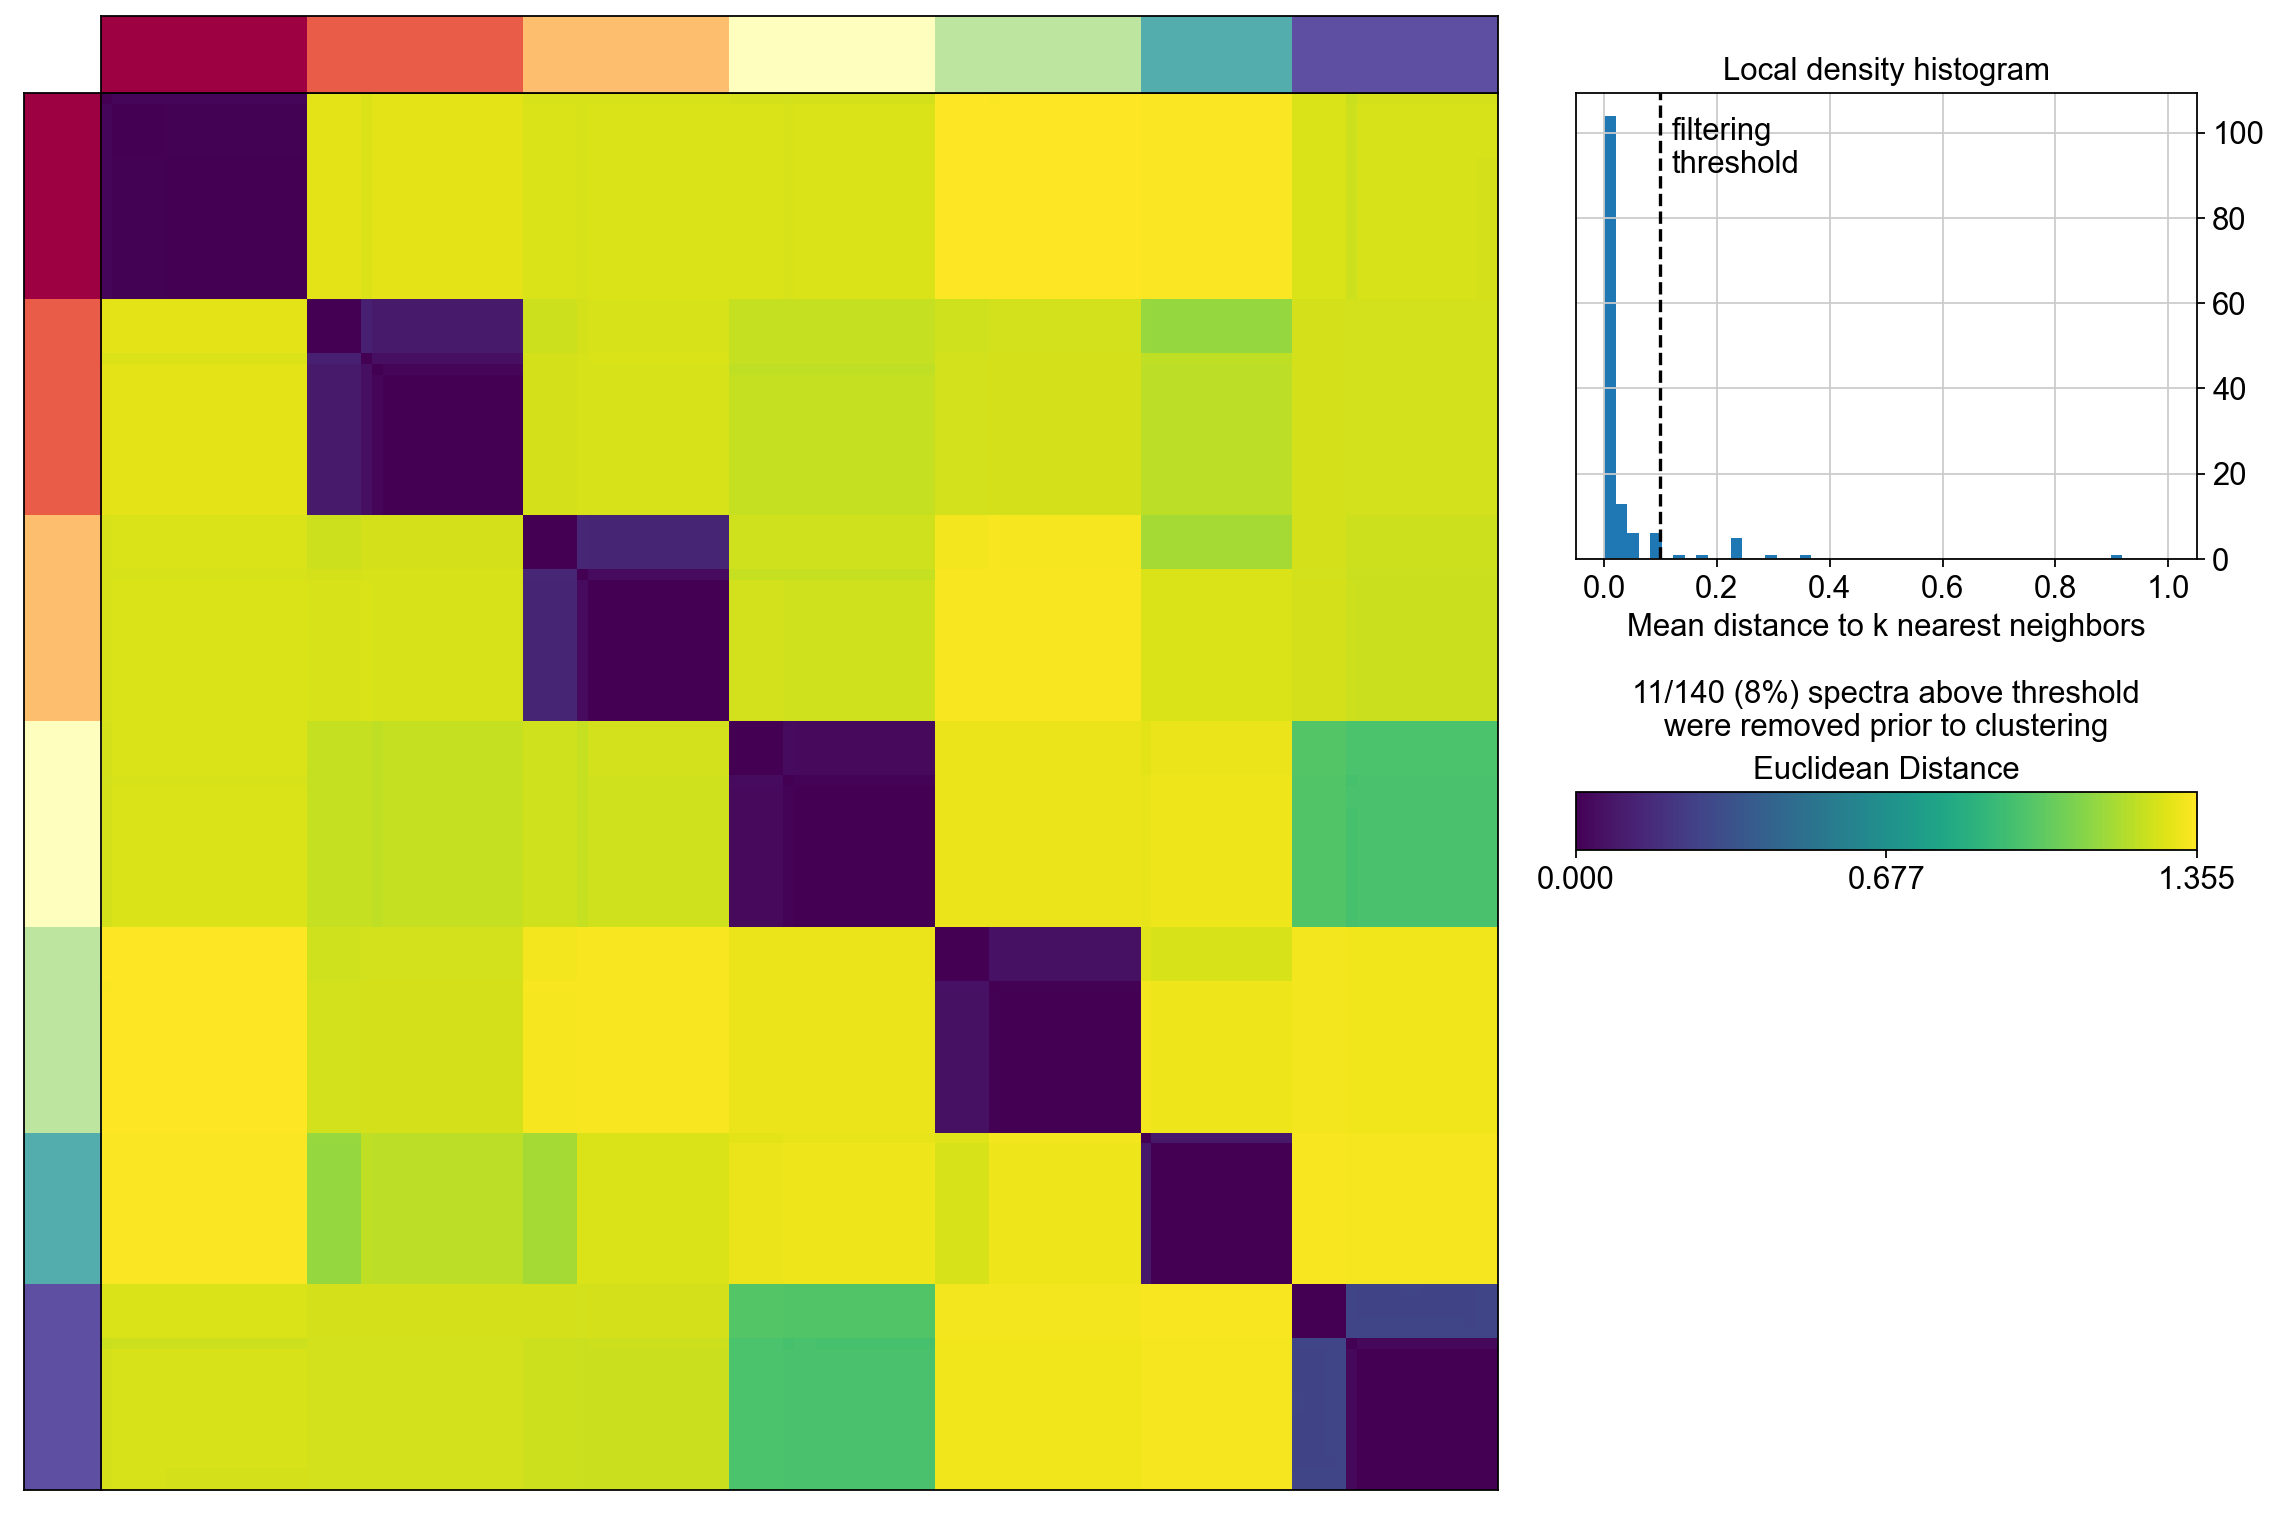

In [13]:
cnmf_obj.consensus(k=selected_K, 
                   density_threshold=density_threshold, 
                   show_clustering=True, 
                   close_clustergram_fig=False)

## Visualization the result

[Text(1, 0.0, '0.000'),
 Text(1, 0.6773953437805176, '0.677'),
 Text(1, 1.3547906875610352, '1.355')]

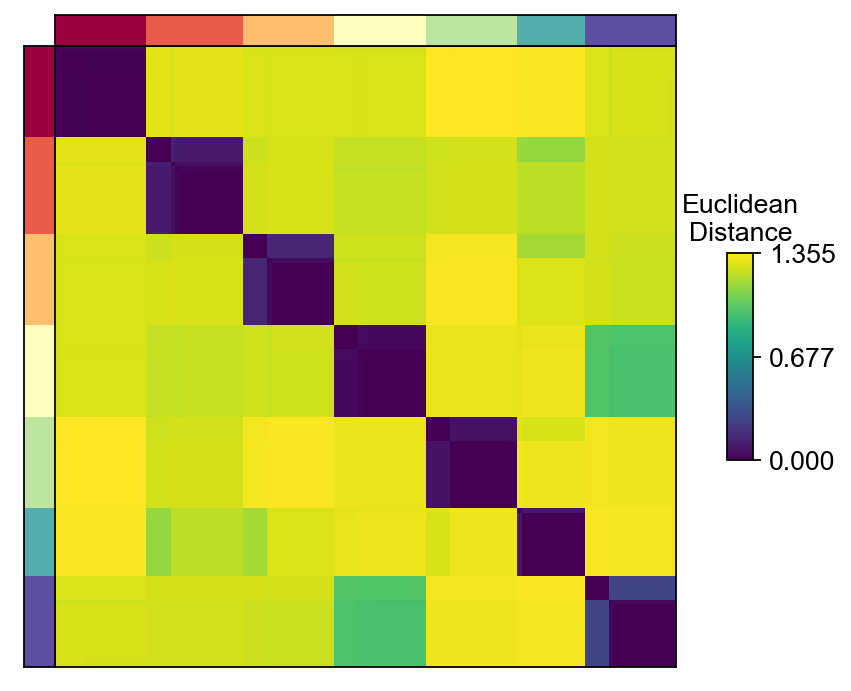

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patheffects

from matplotlib import gridspec
import matplotlib.pyplot as plt

width_ratios = [0.2, 4, 0.5, 10, 1]
height_ratios = [0.2, 4]
fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)))
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios), fig,
                        0.01, 0.01, 0.98, 0.98,
                       height_ratios=height_ratios,
                       width_ratios=width_ratios,
                       wspace=0, hspace=0)
            
D = cnmf_obj.topic_dist[cnmf_obj.spectra_order, :][:, cnmf_obj.spectra_order]
dist_ax = fig.add_subplot(gs[1,1], xscale='linear', yscale='linear',
                                      xticks=[], yticks=[],xlabel='', ylabel='',
                                      frameon=True)
dist_im = dist_ax.imshow(D, interpolation='none', cmap='viridis',
                         aspect='auto', rasterized=True)

left_ax = fig.add_subplot(gs[1,0], xscale='linear', yscale='linear', xticks=[], yticks=[],
                xlabel='', ylabel='', frameon=True)
left_ax.imshow(cnmf_obj.kmeans_cluster_labels.values[cnmf_obj.spectra_order].reshape(-1, 1),
                            interpolation='none', cmap='Spectral', aspect='auto',
                            rasterized=True)

top_ax = fig.add_subplot(gs[0,1], xscale='linear', yscale='linear', xticks=[], yticks=[],
                xlabel='', ylabel='', frameon=True)
top_ax.imshow(cnmf_obj.kmeans_cluster_labels.values[cnmf_obj.spectra_order].reshape(1, -1),
                  interpolation='none', cmap='Spectral', aspect='auto',
                    rasterized=True)

cbar_gs = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1, 2],
                                   wspace=0, hspace=0)
cbar_ax = fig.add_subplot(cbar_gs[1,2], xscale='linear', yscale='linear',
    xlabel='', ylabel='', frameon=True, title='Euclidean\nDistance')
cbar_ax.set_title('Euclidean\nDistance',fontsize=12)
vmin = D.min().min()
vmax = D.max().max()
fig.colorbar(dist_im, cax=cbar_ax,
        ticks=np.linspace(vmin, vmax, 3),
        )
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=12)

Text(0.5, 1.0, 'Local density histogram')

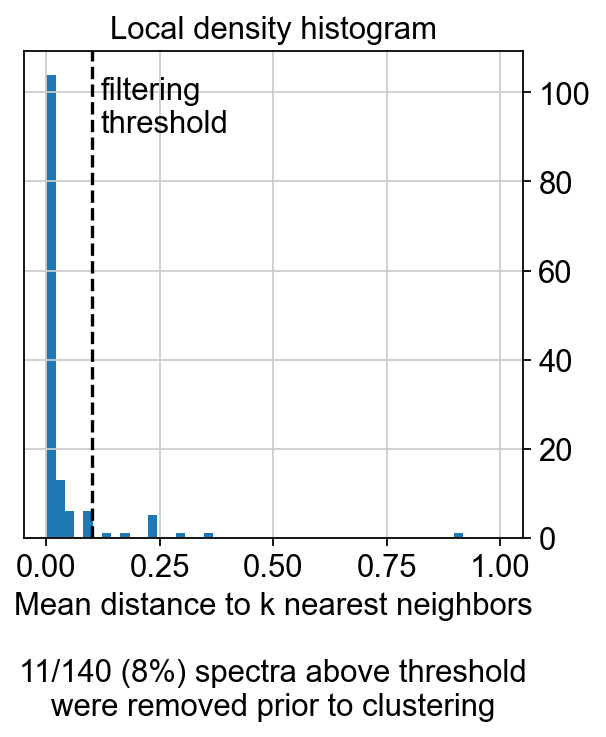

In [15]:
density_filter = cnmf_obj.local_density.iloc[:, 0] < density_threshold
fig, hist_ax = plt.subplots(figsize=(4,4))

#hist_ax = fig.add_subplot(hist_gs[0,0], xscale='linear', yscale='linear',
 #   xlabel='', ylabel='', frameon=True, title='Local density histogram')
hist_ax.hist(cnmf_obj.local_density.values, bins=np.linspace(0, 1, 50))
hist_ax.yaxis.tick_right()

xlim = hist_ax.get_xlim()
ylim = hist_ax.get_ylim()
if density_threshold < xlim[1]:
    hist_ax.axvline(density_threshold, linestyle='--', color='k')
    hist_ax.text(density_threshold  + 0.02, ylim[1] * 0.95, 'filtering\nthreshold\n\n', va='top')
hist_ax.set_xlim(xlim)
hist_ax.set_xlabel('Mean distance to k nearest neighbors\n\n%d/%d (%.0f%%) spectra above threshold\nwere removed prior to clustering'%(sum(~density_filter), len(density_filter), 100*(~density_filter).mean()))
hist_ax.set_title('Local density histogram')

## Explode the cNMF result

We can load the results for a cNMF run with a given K and density filtering threshold like below

In [16]:
result_dict = cnmf_obj.load_results(K=selected_K, density_threshold=density_threshold)


In [17]:
result_dict['usage_norm'].head()

,cNMF_1,cNMF_2,cNMF_3,cNMF_4,cNMF_5,cNMF_6,cNMF_7
index,,,,,,,
AAACATACCCATGA,0.914821,0.069665,0.002832,0.005696,0.005766,0.001195,0.000025
AAACATACCGTAGT,0.000000,0.301103,0.543826,0.023798,0.060927,0.023314,0.047031
AAACATACGAGAGC,0.825390,0.124058,0.000000,0.004974,0.022173,0.023405,0.000000
AAACATACTGAGGG,0.418441,0.573022,0.000000,0.000000,0.008537,0.000000,0.000000
AAACATTGGCATCA,0.883919,0.110361,0.003373,0.002347,0.000000,0.000000,0.000000


In [18]:
result_dict['gep_scores'].head()

,1,2,3,4,5,6,7
Lypla1,-0.000012,-0.000070,-0.000095,0.000215,0.000309,-0.000071,0.000432
Tcea1,-0.000211,-0.000096,0.001432,-0.000163,-0.000086,-0.000175,-0.000141
Atp6v1h,0.000046,0.000319,-0.000197,0.000009,0.000036,-0.000166,-0.000201
Rb1cc1,0.000136,-0.000220,-0.000148,-0.000243,-0.000111,-0.000225,-0.000147
St18,0.000120,-0.000202,-0.000154,-0.000125,-0.000053,0.000151,-0.000080


In [19]:
result_dict['gep_tpm'].head()

,1,2,3,4,5,6,7
Lypla1,1.012847,0.311287,0.000000,6.494763,6.963780,0.000000,24.457178
Tcea1,32.570347,27.502842,252.423310,21.467380,23.251143,9.686699,26.185205
Atp6v1h,40.000793,58.335735,25.865765,36.157150,57.238290,19.569752,0.000000
Rb1cc1,127.013260,58.164032,55.336044,24.606293,24.628428,28.410784,29.346983
St18,15.117199,0.000000,0.000000,0.000000,0.000000,24.502268,0.000000


In [20]:
result_dict['top_genes'].head()

,1,2,3,4,5,6,7
0,Sepw1,Tubb2b,Atp1a2,Lgmn,Cldn5,Cldn11,Pcolce
1,Slc17a7,Tuba1b,Slc1a2,C1qa,Esam,Plp1,Col1a2
2,Ndrg4,Tuba1a,Mlc1,Tyrobp,Bsg,Mbp,Col1a1
3,Snca,Tmsb10,Prdx6,C1qc,Cd34,Mog,Igf2
4,Sncb,Tubb5,Aldoc,C1qb,Srgn,Mag,Slc6a13


In [21]:
cnmf_obj.get_results(adata,result_dict)

cNMF_cluster is added to adata.obs
gene scores are added to adata.var


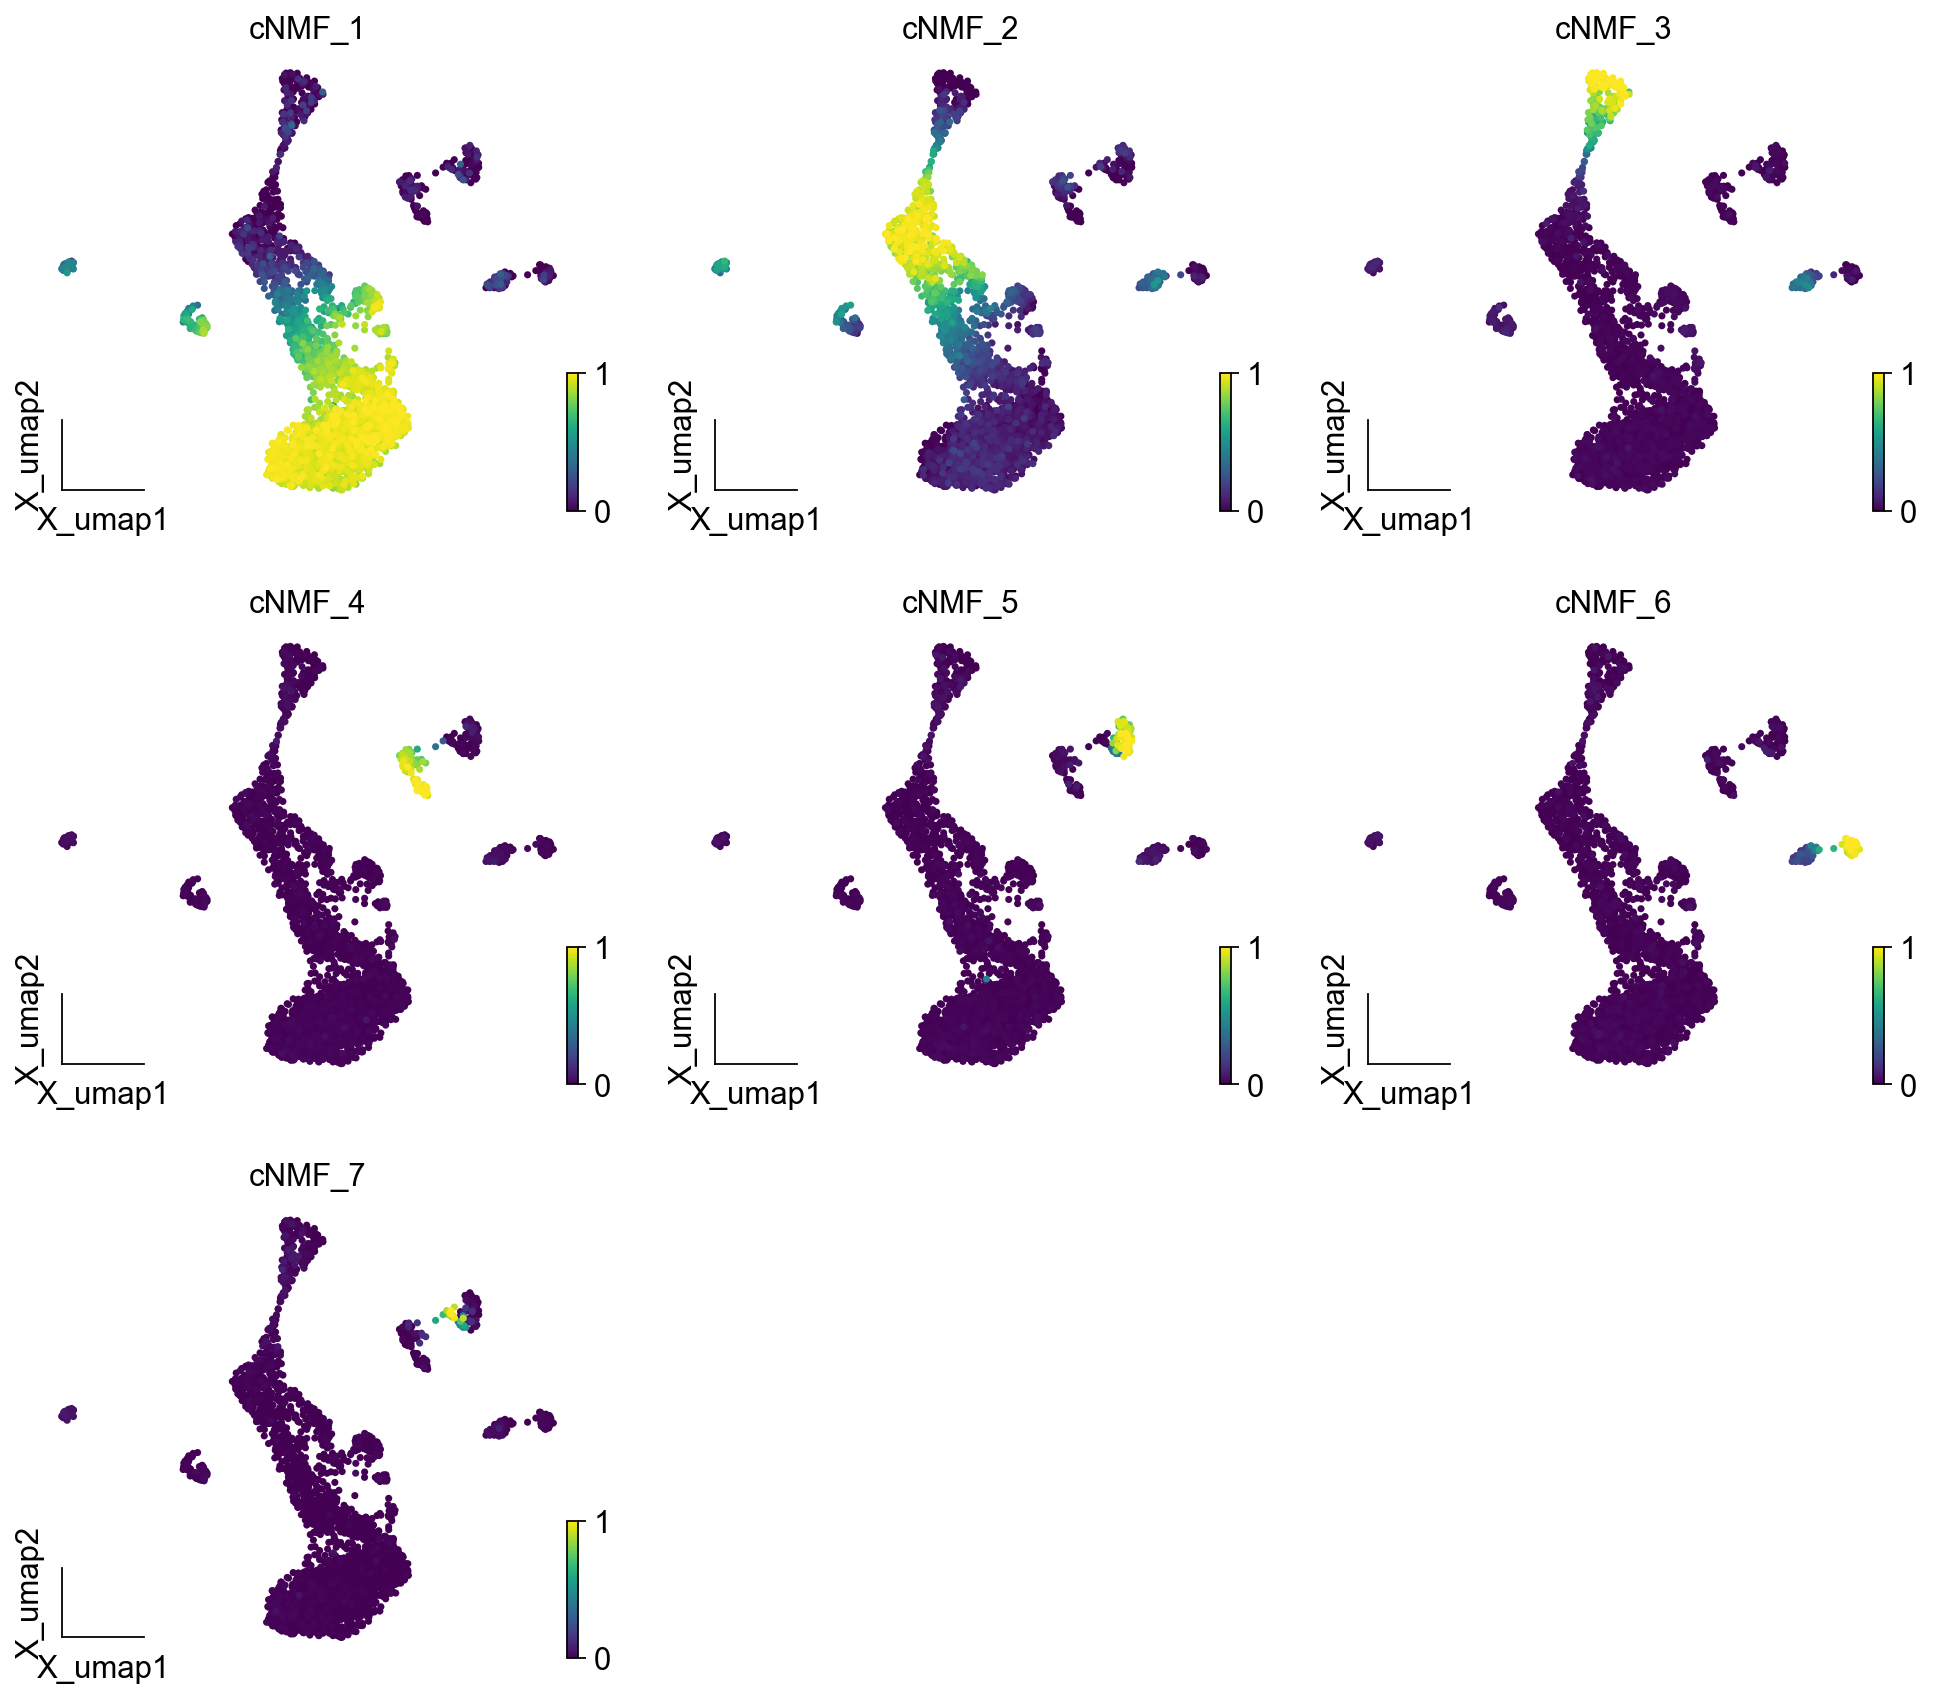

In [23]:
ov.pl.embedding(adata, basis='X_umap',color=result_dict['usage_norm'].columns,
           use_raw=False, ncols=3, vmin=0, vmax=1,frameon='small')

<AxesSubplot: title={'center': 'cNMF_cluster'}, xlabel='X_umap1', ylabel='X_umap2'>

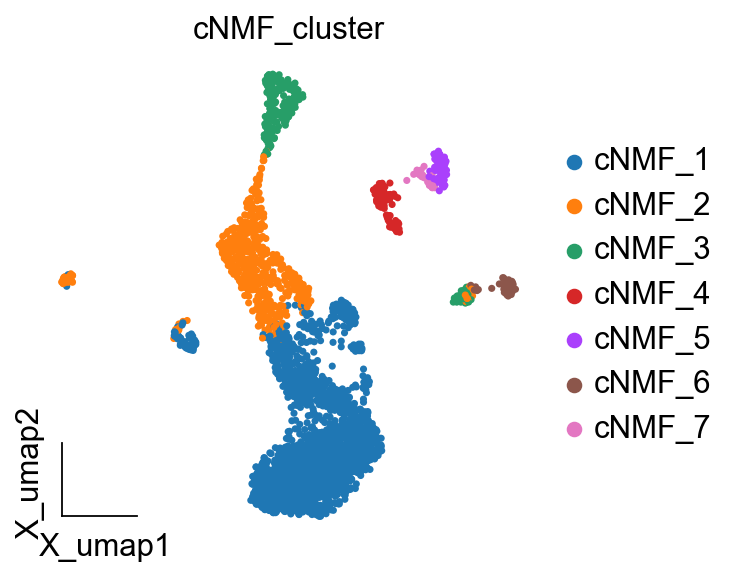

In [24]:
ov.pl.embedding(
    adata,
    basis="X_umap",
    color=['cNMF_cluster'],
    frameon='small',
    #title="Celltypes",
    #legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=2,
    #size=10,
    #legend_loc=True, 
    add_outline=False, 
    #add_outline=True,
    outline_color='black',
    outline_width=1,
    show=False,
)

In [25]:
plot_genes=[]
for i in result_dict['top_genes'].columns:
    plot_genes+=result_dict['top_genes'][i][:3].values.reshape(-1).tolist()

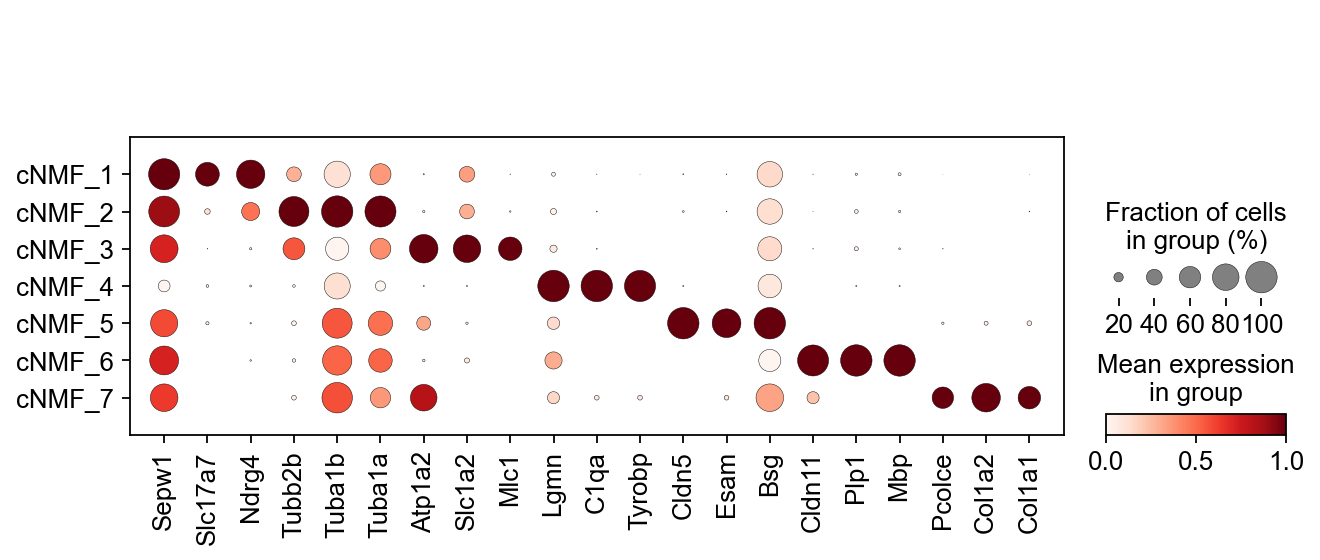

In [26]:
sc.pl.dotplot(adata,plot_genes,
              "cNMF_cluster", dendrogram=False,standard_scale='var',)